# Speech emotion recoginition using PyTorch - EDA and Modelling

**James Morgan (jhmmorgan)**

_2022-04-20_

# 📖 Background

Humans are really good at understanding the emotion behind spoken words.  Does someone sound happy, or angry? Can we build an AI to do this and if so why would we want to when we're already so good at it?

We're good at understanding emotion because it's vital to our communication.  We react and respond differently to people depending on their emotional state, be it happy, sad, angry or another emotion.

Having an AI complete this task can provide great advantage in so many different ways, many of which wouldn't be possible by us; from having digital assistance tools (think Siri and Alexa) understand the emotional intend of a request, to a business analysing their calls to identify potential complaints or the general mood of their customers. You could also apply this in a call center telephony routing, where the system picks up angry or upset customers and transfers them to a human to prevent further agitation.

This is also where AI can really help because we can process audio in bulk or without human intervention.  Rather than having a person listen to a sample of calls, an AI can listen to a large volume without an invasion of privacy, whilst outputting the general positive or negative nature of their customers.

### The Task
Our task is to create a model that can predict the emotion of spoken audio.

Within this task, we'll need to perform exploratory data analysis (EDA) to understand the how we can utilse machine learning techniques on audio files and how we can process these files ready for modelling.

------

# 📚 Libraries
We'll start by loading all the required libaries.

Within this, we'll also load **utils.py**, which is a custom script that includes improved print functionality, allowing us to easily print styles, such as boldness, underlined, highlighting and different colours.

In [1]:
from utils import *
from audio_utility import *
from audio_model import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#import pydub
#from pydub import AudioSegment
#from pydub.playback import play

import torch, torchaudio
from torch.utils.data import DataLoader, Dataset, random_split

from sklearn.metrics import confusion_matrix
import seaborn as sns

---
# 🗂 Loading Data
For our training model, we have recordings from 24 equally split male and female actors, each with over 50 recordings each.  The recordings are one of two statements
* **"Kids are talking by the door"**
* **"Dogs are sitting by the door"**

Each recording is spoken in one of 8 different emotions:
* **Neutral**, **Calm**, **Happy**, **Sad**, **Angry**, **Feaful**, **Disgust** or **Surprised**.

The recording can also have a normal, or strong emotional intensity.

We have no accommpanying csv / data file, however the file name of each audio file contains a set of numbers, seperated by a dash (-), which contains all the information we need, e.g. 03-01-08-02-02-01-01.wav contains 7 bits of information.

So the first thing we need to do is scan through the data, and extract the relevant information into a dataframe.  The 7 bits of information are:
* **Modality** (01 = full-AV, 02 = video-only, 03 = audio-only).
* **Vocal channel** (01 = speech, 02 = song).
* **Emotion** (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* **Emotional** intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* **Statement** (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* **Repetition** (01 = 1st repetition, 02 = 2nd repetition).
* **Actor** (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [2]:
data_folder = "./data/"

# Function to extract each bit of information.  The emotions range from 1 to 8, however we'll reduce the number by 1, 
#  so it'll instead be a range from 0 to 7.
def data_from_list(data):
    modality   = int(data[0])
    vocal      = int(data[1])
    emotion    = int(data[2])-1
    intensity  = int(data[3])
    statement  = int(data[4])
    repetition = int(data[5])
    actor      = int(data[6])
    gender     = 0 if ((actor % 2) == 0) else 1
    
    output = [actor, gender, modality, vocal, emotion, intensity, statement, repetition]

    return(output)

# We'll loop through every file in every sub-folder of our data folder to extract the information needed for our audio data
# We're not loading the audio files here, we're extracting the relevant information from the file names and saving this as
#   as data frame.
data_directory = os.listdir(data_folder)
data_directory.remove(".DS_Store")
data_directory.sort()
file_data = []

for actors_folder in data_directory:
    actors_folder_full = data_folder + actors_folder
    files = os.listdir(actors_folder_full)
    for file in files:
        name, ext = os.path.splitext(file)
        data = data_from_list(name.split("-"))
        data.append(ext)
        data.append(actors_folder_full + "/" + file)
        file_data.append(data)

full_data = pd.DataFrame(file_data, 
             columns=["actor", "gender", "modality", "vocal", "emotion", "intensity", "statement", "repetition", 
                      "ext", "full_path"])

#full_data["gender"] = pd.Categorical(full_data["gender"], categories)

full_data = full_data.replace({#"gender"   : {0: "male", 1:"female"},
                               "modality" : {1: "full-av", 2: "video-only", 3: "audio-only"},
                               "vocal"    : {1: "speech", 2: "song"}})
                               #"emotion"  : {1: "neutral", 2: "calm", 3: "happy", 4: "sad", 5: "angry",
                               #              6: "fearful", 7: "disgust", 8: "surprised"}})
full_data["gender"] = pd.Categorical(full_data["gender"])
full_data["modality"] = pd.Categorical(full_data["modality"])
full_data["vocal"] = pd.Categorical(full_data["vocal"])
full_data["emotion"] = pd.Categorical(full_data["emotion"])

#full_data = full_data[(full_data.emotion == 3) | (full_data.emotion == 5)]
#full_data = full_data.replace({"emotion" : {3: 0, 5:1}}).reset_index(drop=True)
full_data.head()

,actor,gender,modality,vocal,emotion,intensity,statement,repetition,ext,full_path
0,1,1,audio-only,speech,7,2,2,1,.wav,./data/Actor_01/03-01-08-02-02-01-01.wav
1,1,1,audio-only,speech,7,1,1,1,.wav,./data/Actor_01/03-01-08-01-01-01-01.wav
2,1,1,audio-only,speech,4,1,2,1,.wav,./data/Actor_01/03-01-05-01-02-01-01.wav
3,1,1,audio-only,speech,5,1,2,2,.wav,./data/Actor_01/03-01-06-01-02-02-01.wav
4,1,1,audio-only,speech,5,2,1,2,.wav,./data/Actor_01/03-01-06-02-01-02-01.wav


---
# 🎶 ADA (Audio Data Analysis)

Great! Now we have a dataframe that contains links to the audio files and it's accommpanying data, let's see what this looks (and sounds) like.

In [3]:
from IPython.display import Audio
emotion_lookup = {0: "neutral", 1: "calm", 2: "happy", 3: "sad", 4: "angry",
                  5: "fearful", 6: "disgust", 7: "surprised"}


index = 5
print2.bold(f"Actor: {full_data.iloc[index].actor}, Emotion: {emotion_lookup.get(full_data.iloc[index].emotion)}, Statement: {full_data.iloc[index].statement}")
Audio(full_data.iloc[index].full_path)

Actor: 1, Emotion: angry, Statement: 1


In [4]:
index = 70
print2.bold(f"Actor: {full_data.iloc[index].actor}, Emotion: {emotion_lookup.get(full_data.iloc[index].emotion)}, Statement: {full_data.iloc[index].statement}")
Audio(full_data.iloc[index].full_path)

Actor: 2, Emotion: happy, Statement: 2


In [5]:
index = 200
print2.bold(f"Actor: {full_data.iloc[index].actor}, Emotion: {emotion_lookup.get(full_data.iloc[index].emotion)}, Statement: {full_data.iloc[index].statement}")
Audio(full_data.iloc[index].full_path)

Actor: 4, Emotion: disgust, Statement: 2


We have a custom class that allows us to open our audio files and allows us to either play this, or convert it.  Converting / Processing the audio is vital for this task.

Not all audio files are the same. Two key attributes are:
* **Channels**. Audio can be mono (1 channel), Stereo (2 channels) or more.
* **Sample Rate**. Audio is analog but computers are digital.  A sample rate is how many samples of the audio are taken per second.  This is typically 44100Hz or 48000Hz.

Each sample contains data and so considering how many samples are taken per second, even a three second audio file contains a lot of data.  Whilst we could use this to train our models, it wouldn't be very effective.

Instead, we're more interested in spectograms... specifically mel spectograms.  So what are they?

Without getting too tecnical, we can think of a spectrogram as a way to visually represent the audios loudness, or amplitude, as it varies over time at different frequencies. It's like a heatmap of the loudness of each frequency over time.

Humands do not perceive frequencies on a linear scale.  We can detect differences in lower frequencies better than higher frequencies.  We can easily tell the difference between 500Hz and 1000Hz, but we struggle to tell teh difference between 10,000Hz and 10,500Hz.

And so a Mel Scale is a unit of pitch, where equal distances in pitch sound equally distent to humans. It's not a log scale, but similar to a log scale, 500Hz and 1000Hz are further apart than 10,000Hz and 10,500Hz.

We therefore want to transform our audio so:
* They all have the same number of **channels**.
* They all have the same **sample rate**.
* They are all of the same length (by extending it's duration by padding it with silence, or truncating it).
* They are then converted into a mel-spectogram image.

Ok, so what does a mel-spectogram image look like?

# 

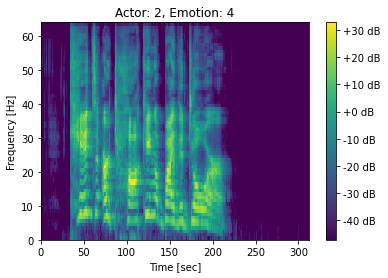

In [6]:
audio = AudioUtility()
sound_id    = 100
sound_title = f"Actor: {full_data.iloc[sound_id]['actor']}, Emotion: {full_data.iloc[sound_id]['emotion']}"
sound_path  = full_data.iloc[sound_id]["full_path"]

sound = audio.open(sound_path)
sound = audio.rechannel(sound, 2)

sound = audio.cut_silence_at_start(sound)

sound = audio.spectro_gram(sound, n_mels=64, n_fft=1028, hop_len=None)
sound_array = np.asarray(sound[0])

plt.title(sound_title)
plt.pcolormesh(sound_array)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(format='%+2.0f dB')
plt.show()

---
# 🛠 Pre-Processing

In addition to converting the audio to a mel-spectogram, we also want to perform some pre-processing of the image to help our models, by decreasing the potential for over-fitting whilst increasing the number of audio samples to train from.

We can do this from amending the image in various different ways, such as cutting silence from the start of the audio, shifting the audio in time (forward or back) by up to 40% and adding various masks to either the frequency or time.

This is what the resulting image looks like

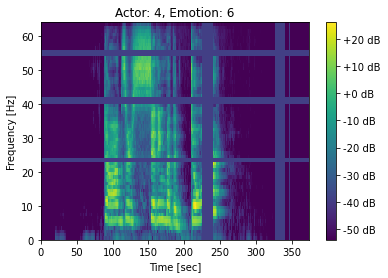

In [7]:
audio = AudioUtility()
sound_id    = 200
sound_title = f"Actor: {full_data.iloc[sound_id]['actor']}, Emotion: {full_data.iloc[sound_id]['emotion']}"
sound_path  = full_data.iloc[sound_id]["full_path"]

sound = audio.open(sound_path)
sound = audio.rechannel(sound, 2)

sound = audio.cut_silence_at_start(sound)

sound = audio.pad_trunc(sound, 4000)
sound = audio.time_shift(sound, 0.4)

sound = audio.spectro_gram(sound, n_mels=64, n_fft=1028, hop_len=None)
sound = audio.spectro_augment(sound, max_mask_pct=0.05, n_freq_masks=4, n_time_masks=4)
sound_array = np.asarray(sound[0])

plt.title(sound_title)
plt.pcolormesh(sound_array)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(format='%+2.0f dB')
plt.show()

---
# ⚙️ Machine Learning - Configuation

We're now ready to start our machine learning configuation.

The first thing we need to do is create a dataloader for our audio files. We'll want to split our data into train and validation subsets and create a dataloader for each.

I was tempted to use the features of the file (gender, intensity etc) to improve the model. The model does allow this by passing the features into the features variable.  However, I've deviced to train the model without this, because if we were to deploy this model, that information wouldn't be available from just an audio submission.

In [8]:
features = ["gender", "intensity", "statement", "repetition"]
#data = Sound_DataLoader(full_data, target = "emotion", audio_path = "full_path", feature = features)
data = Sound_DataLoader(full_data, target = "emotion", audio_path = "full_path")

num_items = len(data)
num_train = round(num_items * 0.8)
num_valid = int(num_items - num_train)
train, validation = random_split(data, [num_train, num_valid])

#num_valid = int((num_items - num_train)/2)
#num_test  = num_items - num_train - num_valid
#train, validation, test = random_split(data, [num_train, num_valid, num_test])

# Create training and validation data loaders
train_dataload      = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
validation_dataload = torch.utils.data.DataLoader(validation, batch_size=1, shuffle=False)
#test_dataload       = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

We'll then want to create our model and run it.

In [9]:
# Create the model and put it on the GPU if available
model  = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model  = model.to(device)

# Check that it is on Cuda
#next(model.parameters()).device

In [10]:
sm = speech_model(model = model, epochs=200, verbose = 1, device = device)
sm.fit(train_dataload, validation_dataloader = validation_dataload)
sm.evaluate(validation_dataload)

 Fitting model 
Epoch: 1 of 200		Loss: 2.061	Accuracy: 15.97%	Validation Accuracy: 13.76%                    
Epoch: 10 of 200		Loss: 1.647	Accuracy: 38.89%	Validation Accuracy: 29.24%                   
Epoch: 20 of 200		Loss: 1.391	Accuracy: 49.39%	Validation Accuracy: 44.57%                   
Epoch: 30 of 200		Loss: 1.137	Accuracy: 58.59%	Validation Accuracy: 47.73%                   
Epoch: 40 of 200		Loss: 0.889	Accuracy: 68.32%	Validation Accuracy: 50.70%                   
Epoch: 50 of 200		Loss: 0.701	Accuracy: 75.69%	Validation Accuracy: 57.27%                   
Epoch: 60 of 200		Loss: 0.609	Accuracy: 80.21%	Validation Accuracy: 58.61%                   
Epoch: 70 of 200		Loss: 0.455	Accuracy: 83.07%	Validation Accuracy: 68.62%                   
Epoch: 80 of 200		Loss: 0.305	Accuracy: 89.76%	Validation Accuracy: 59.59%                   
Epoch: 90 of 200		Loss: 0.253	Accuracy: 91.15%	Validation Accuracy: 65.08%                   
Epoch: 100 of 200		Loss: 0.208	Accuracy: 92.

In [11]:
predictions = sm.predict(validation_dataload)
labels      = validation_dataload.dataset.dataset.df.iloc[validation_dataload.dataset.indices].emotion

cm = confusion_matrix(labels, predictions)


---
# 🎓 Summary

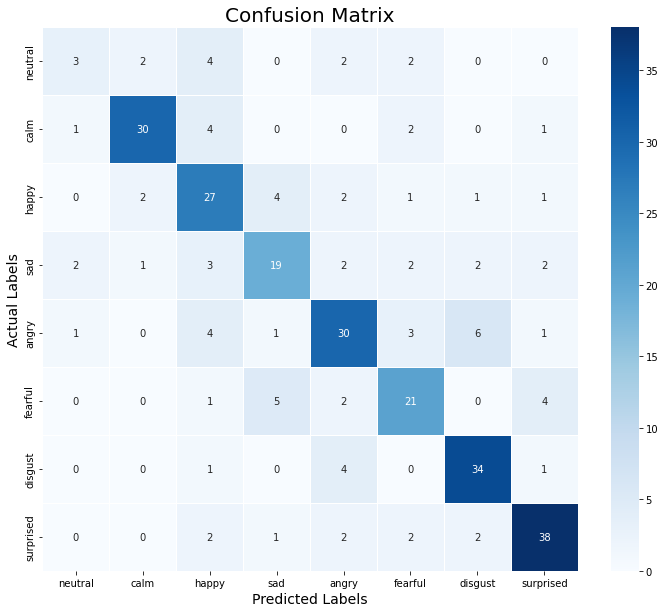

In [12]:
emotion_list = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
cm = pd.DataFrame(cm, index = [i for i in emotion_list], columns = [i for i in emotion_list])

plt.figure(figsize = (12, 10))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

Our accuracy on the validation dataset is a little over 75%, which I consider to be quite good, considering a random prediction would be 12.5%.

Whilst it could be better, by visualising the predictions over a heatmap, we can see that in general, it'll predict the right emotion.  Some emotions that are closer together like anger and disgust are occasionally confused and it performs worse with a netural emotion.

We could work on improving our model, however as a working concept, our current model will do.

That said, to fully understand just how confident the model is at predicting each emotion, we could look at percentages.  There are two ways of doing this
* Looking at the accuracy of each correct prediction
* Looking at the probability of each emotion per prediction

Whilst the first way might seem more intuitive, e.g., if we correctly predicted 6 out of 10 happy emotions were infact happy, we'd have an accuacy of 60%, which is what we've done when we evaluated the whole model, we can instead look at each emotions probability.

The way our model works is that it'll predict the probability of a speech being any of the eight emotions.  For example, it might predict a sad emotion to have a 30% probability of being sad, with a 10% probability for each of the other 7 emotions.
The highest percentage wins, and so in this example, we'll correctly predict the emotion is sad even though the model was only 30% confident.

This is how our model predicts the probability of each emotion, per prediction:

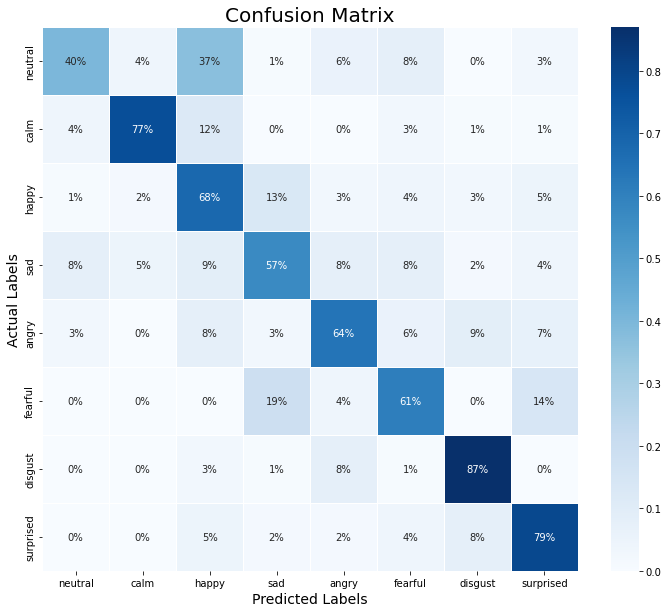

In [13]:
predictions = sm.predict(validation_dataload, return_all = True)
labels      = validation_dataload.dataset.dataset.df.iloc[validation_dataload.dataset.indices].emotion.reset_index(drop=True)    

emotion_list = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
pred_df = pd.DataFrame(0.0, index = [i for i in emotion_list], columns = [i for i in emotion_list])

for i in range(len(predictions)):
    label = int(labels[i])
    preds = predictions[i][0]
    pred_df.iloc[label] += preds

for i in range(len(pred_df)):
    pred_df.iloc[i] = round((pred_df.iloc[i] / round(pred_df.iloc[i].sum(),2)),2)



plt.figure(figsize = (12, 10))
sns.heatmap(pred_df, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.0%')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()